In [1]:
import pickle
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_curve,auc
from utils import multiple_model_stats
from matplotlib import pyplot as plt
from matplotlib import patches
from numpy import interp
import numpy as np
import seaborn as sns
import pandas as pd

models_with_data_aug_path = Path('./histories/models_predictions_with_data_aug/')
models_without_data_aug_path = Path('./histories/model_prediction_without_data_aug/')
nkfolds = Path('./histories/nkfoldResults/')
nkfolds_noAUG = Path('./histories/nkfolds_nodAug/')

In [27]:
models_predictions_path = models_with_data_aug_path
for file_p in models_predictions_path.iterdir():
        if not file_p.is_file(): continue
        with open(str(file_p),'rb') as file:
            model_kfold_predictions = pickle.load(file)
        print(model_kfold_predictions[0][-1])
        print('!!!!!!!!!!!!!!!!!')

CNN + KNN
!!!!!!!!!!!!!!!!!
CNN
!!!!!!!!!!!!!!!!!
CNN + SVM
!!!!!!!!!!!!!!!!!
CNN + RF
!!!!!!!!!!!!!!!!!


In [10]:
results_daug = []
# fig1 =plt.figure()
# ax1 = fig1.add_subplot(111,aspect='equal')
# ax1.add_patch(patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha=0.5))
# ax1.add_patch(patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha=0.5))

        
def plot_models_rocs_curves(models_predictions_path, title_label='', plot_joined_rocs=True, spanish_caption=True):
    
    if spanish_caption:
        xlabel = 'Grado de Falsos Positivos'
        ylabel = 'Grado de Verdaderos Positivos'
        joinedRocsTitleLabel = "ROC de los Modelos"
    else:
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        joinedRocsTitleLabel = "Model's ROC"
        
    for file_p in models_predictions_path.iterdir():
        if not file_p.is_file(): continue
        with open(str(file_p),'rb') as file:
            model_kfold_predictions = pickle.load(file)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1,100)
        i = 1
        model_name = model_kfold_predictions[0][-1] + " " + title_label if title_label != '' else model_kfold_predictions[0][-1]
        
        model_name = model_name.replace("K","k-")
        
        for y_test,y_pred,_ in model_kfold_predictions:
            fpr,tpr,t = roc_curve(y_test,y_pred)
            tprs.append(interp(mean_fpr,fpr,tpr))
            roc_auc = auc(fpr,tpr)
            aucs.append(roc_auc)
            label=''
            if len(model_kfold_predictions)<=5:
                label = f'fold {i} (AUC = {np.round(roc_auc,3)})'
            plt.plot(fpr,tpr,lw=2,alpha=0.3,label=label)
            i += 1
        plt.plot([0,1],[0,1],linestyle='--',lw=2,color='black')
        mean_tpr = np.mean(tprs,axis=0)
        mean_auc = auc(mean_fpr,mean_tpr)
        
        results_daug.append((mean_fpr,mean_tpr,mean_auc, model_name))
        
        if spanish_caption:
            label_plot = f'ROC Promedio {model_name} (AUC = {np.round(mean_auc,3)})'
        else:
            label_plot = f'Mean ROC {model_name} (AUC = {np.round(mean_auc,3)})'
            
        plt.plot(mean_fpr,mean_tpr,color='blue', label=label_plot,lw=2,alpha=1)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(model_name+ ' ROC')
        plt.legend(loc='lower right')

 

        #plt.show()
        noSpaces = model_name.replace(" ",'')
        plt.savefig(f"{noSpaces}_{title_label}_ROC.png")
        plt.close()

    if plot_joined_rocs:

        for mean_fpr,mean_tpr, mean_auc, model_name in results_daug:
            if spanish_caption:
                label_plot = f'ROC Promedio {model_name} (AUC = {np.round(mean_auc,3)})'
            else:
                label_plot = f'Mean ROC {model_name} (AUC = {np.round(mean_auc,3)})'
                
            plt.plot(mean_fpr,mean_tpr, label=label_plot,lw=2,alpha=1) 

        plt.plot([0,1],[0,1],linestyle='--',lw=2,color='black')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(joinedRocsTitleLabel)
        plt.legend(loc='lower right')

        #plt.show()
        plt.savefig(f"{noSpaces}_{title_label}_joined_ROC.png")
        plt.close()

In [58]:
plot_models_rocs_curves(models_with_data_aug_path)
plot_models_rocs_curves(models_without_data_aug_path,'No AUG',False)

In [26]:
def plot_aug_comp(spanish_caption=True):
    
    if spanish_caption:
        xlabel = 'Grado de Falsos Positivos'
        ylabel = 'Grado de Verdaderos Positivos'
        joinedRocsTitleLabel = "ROC de los Modelos"
    else:
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        joinedRocsTitleLabel = "Model's ROC"

    cnn_models = [i for i in results_daug if i[-1] == 'CNN' or i[-1] == 'CNN No Aug']
    print(len(cnn_models))
    for mean_fpr,mean_tpr, mean_auc, model_name in cnn_models:
#         plt.plot(mean_fpr,mean_tpr, label=f'Mean ROC {model_name} (AUC = {np.round(mean_auc,3)})',lw=2,alpha=1) 
        if spanish_caption:

            label_plot = f'ROC Promedio {model_name} (AUC = {np.round(mean_auc,3)})'
        else:
            label_plot = f'Mean ROC {model_name} (AUC = {np.round(mean_auc,3)})'

        plt.plot(mean_fpr,mean_tpr, label=label_plot,lw=2,alpha=1) 

    plt.plot([0,1],[0,1],linestyle='--',lw=2,color='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(joinedRocsTitleLabel)
    plt.legend(loc='lower right')
    plt.savefig('AugVsNoAugCNN.png')
    plt.close()

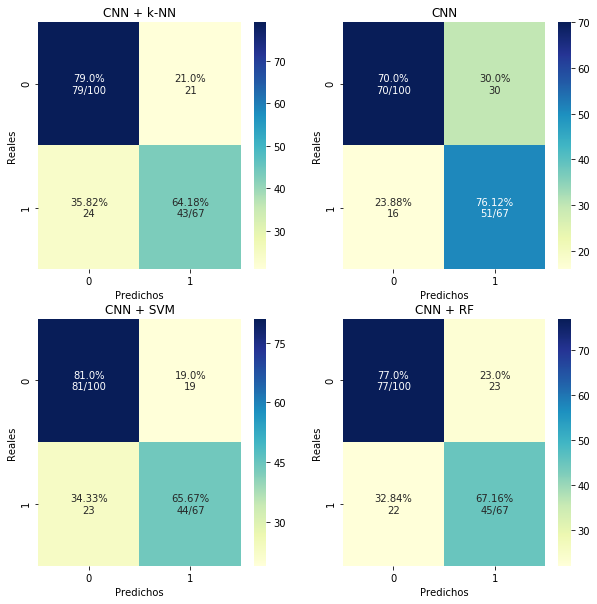

In [11]:
def plot_models_confussion_matrix(models_predictions_path:Path, subplots_rows=2, subplots_cols=2, spanish_caption=True):
    
    if spanish_caption:
        actual_label = "Reales"
        predicted_label = "Predichos"
    else:
        actual_label = "Actual"
        predicted_label = "Predicted"
    
    fig, axis = plt.subplots(subplots_rows,subplots_cols,figsize=(10,10))
    axis = np.ravel(axis)
    
    axis_index = 0
    for file_p in models_predictions_path.iterdir():
        if not file_p.is_file(): continue
        with open(str(file_p),'rb') as file:
            model_kfold_predictions = pickle.load(file)
            
        name = ''
        cm = None
#         print(len(model_kfold_predictions))
        for y_test, y_pred, model_name in model_kfold_predictions:
            
            if cm is None:
                cm = confusion_matrix(y_test,np.round(y_pred),labels=np.unique(y_test))
                name = model_name
            else:
                cm += confusion_matrix(y_test,np.round(y_pred),labels=np.unique(y_test))
    
        cm = np.round(cm / len(model_kfold_predictions))
        cm_sum = np.sum(cm,axis=1,keepdims=True)
        cm_prec = cm /cm_sum.astype(float)*100
        annot = np.empty_like(cm).astype(str)
        
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i,j].astype(int)
                p = cm_prec[i,j]
                
                if i ==j:
                    s = cm_sum[i][0].astype(int)
                    annot[i,j] = '{}%\n{}/{}'.format(round(p,2),c,s)
                elif c == 0:
                    annot[i,j] = ''
                    
                else:
                    annot[i,j] = '{}%\n{}'.format(round(p,2),c)
#         print(len(cm), 'es el len')
        cm = pd.DataFrame(cm,index=np.unique(y_test),columns=np.unique(y_test))
        cm.index.name = actual_label
        cm.columns.name = predicted_label
        ax = axis[axis_index]
        
        ax.set_title(name.replace("K","k-"))
        sns.heatmap(cm,cmap='YlGnBu',annot=annot,fmt='',ax=ax,)
        
        axis_index +=1
        
    fig.savefig('CM.png')

plot_models_confussion_matrix(models_with_data_aug_path)

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
def get_some_models_stats(models_predictions_path:Path):
    for file_p in models_predictions_path.iterdir():
        if not file_p.is_file(): continue
        with open(str(file_p),'rb') as file:
            model_kfold_predictions = pickle.load(file)
            
        name = ''
        cm = np.zeros((1,3))
        for y_test, y_pred, model_name in model_kfold_predictions:
            
            cm[0,0] += precision_score(y_test,np.round(y_pred),labels=np.unique(y_test))
            cm[0,1] += recall_score(y_test,np.round(y_pred),labels=np.unique(y_test))
            cm[0,2] += f1_score(y_test,np.round(y_pred),labels=np.unique(y_test))
            
        cm /= len(model_kfold_predictions)
        
        print(model_name)
        print(cm)

In [38]:
get_some_models_stats(models_with_data_aug_path)

CNN + KNN
[[0.67531258 0.64179104 0.65669862]]
CNN
[[0.64113919 0.7641791  0.69172455]]
CNN + SVM
[[0.69569156 0.65373134 0.67372298]]
CNN + RF
[[0.66735294 0.67761194 0.67225595]]


In [27]:
results_daug = []
plot_models_rocs_curves(nkfolds)

In [28]:
plot_models_rocs_curves(nkfolds_noAUG,'',False)
plot_aug_comp()

2


In [14]:
get_some_models_stats(nkfolds)

CNN
[[0.70032797 0.69131702 0.68805993]]
CNN + KNN
[[0.75643813 0.57434498 0.65105853]]
CNN + RF
[[0.72963554 0.63473909 0.67792166]]
CNN + SVM
[[0.7471949  0.60236088 0.6657292 ]]


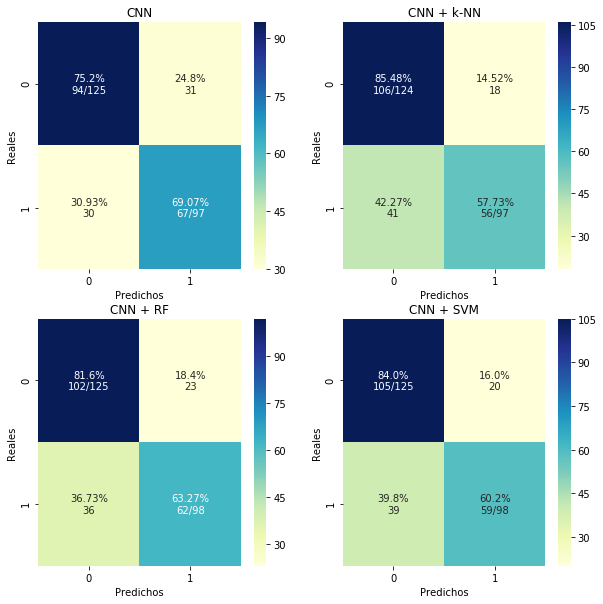

In [15]:
plot_models_confussion_matrix(nkfolds)

In [12]:
# for file_p in nkfolds_noAUG.iterdir():
#     if not file_p.is_file(): continue
#     with open(str(file_p),'rb') as file:
#         model_kfold_predictions = pickle.load(file)
#     model_kfold_predictions2 = [(y_test,_y_pred,model_name+" No Aug") for y_test,_y_pred,model_name in model_kfold_predictions]

In [14]:
# with open(str(file_p),'wb') as file:
#     pickle.dump(model_kfold_predictions2,file)
        

In [6]:
a = "abc1"
a = a.replace("b","cd")

In [7]:
a

'acdc1'